# Pytorch ViT

Taken from the huggingface `timm` collection. This is supposedly a perfectly accurate translation of the jax ViT implementation into pytorch.

TODO: Verify the parity of the implementation

## Setup

Once per machine, we need to clone the appropriate repository and install the necessary dependencies.

In this case we simply clone the entire image models repo.

In [1]:
# experiment params
num_train_trials = 5
num_train_warmups = 1
num_jit_trials = 10
num_jit_warmups = 2
num_inference_trials = 100
num_inference_warmups = 10

In [2]:
![ -d pytorch-image-models] || git clone https://github.com/huggingface/pytorch-image-models.git

zsh:[:1: ']' expected
fatal: destination path 'pytorch-image-models' already exists and is not an empty directory.


In [3]:
!pip install timm
!pip install torch
!pip install torchvision
!pip install pytest
!pip install matplotlib
!pip install tqdm

## Example Usage

From the timm package, we can load a pretrained ViT model and perform inference using it.

In [4]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('vit_base_patch16_clip_384.laion2b_ft_in12k_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

print(top5_probabilities)

tensor([[38.2581, 17.1601,  4.3014,  3.6252,  3.1480]],
       grad_fn=<TopkBackward0>)


## Setup our environment

Since we need to actually time the jitting of the VisionTransformer model, we cannot simply rely on the hugging face implementation and thus need to dig into the repo in order to get the accurate timing information

In [5]:
import sys

# Add the timm repo to the system path
sys.path.append("./pytorch-image-models/timm")

# check that we can actually import the ViT class
from timm.models.vision_transformer import VisionTransformer

## Get Sample Data

In [6]:
import os
import PIL

!mkdir -p inference

def filecount(dir: str) -> int:
    file_count = 0
    for entry in os.scandir(dir):
        if entry.is_file():
            file_count += 1
    return file_count

if not (filecount("inference") >= num_inference_trials):
    resolution = 384  # parity with the JAX version tested
    for index in range(1, num_inference_trials + 1):
        output = f"picsum{index}.jpg"
        !wget https://picsum.photos/$resolution -O inference/$output

## Timing the ViT compilation

We perform the same measurement as we did on the JAX ViT, compiling the model a given number of times and taking the average of the last n runs to give a good result.

In [7]:
import tqdm
import time


# Recommended from the torch documentation on JIT
# https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html
#def timed():
#    start = torch.cuda.Event(enable_timing=True)
#    end = torch.cuda.Event(enable_timing=True)
#    start.record()
#    result = jitted(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1
#    end.record()
#    torch.cuda.synchronize()
#    return result, start.elapsed_time(end) / 1000

vit = VisionTransformer(img_size = 384)

@torch.compile
def run_jit(img):
    return vit(transforms(img).unsqueeze(0))


# TODO: Get dan's help, something isn't right with this measurement
def time_jit(num_jit_runs: int, num_jit_warmups: int) -> float:
    times = []
    for i in tqdm.trange(1, num_jit_runs + 1):
        inp = PIL.Image.open(f"inference/picsum1.jpg")        
        start_jit = time.time()

        result = run_jit(img)

        end_jit = time.time()

        torch.compiler.reset()
        if i >= num_jit_warmups:
            times.append(end_jit - start_jit)

    return sum(times) / len(times)

average_jit_time = time_jit(num_jit_trials, num_jit_warmups)

print(f"Average JIT time: {average_jit_time}")

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.41s/it]

Average JIT time: 4.272155814700657


## Timing ViT Inference

Same measurement as in the JAX 

In [8]:
track = 0
inference_times = []
for i in tqdm.trange(1, num_inference_trials + 1):
    img = PIL.Image.open(f"inference/picsum{i}.jpg")
    start_inference = time.time()
    
    # note that this is not saturating the GPU, a larger batch size would be better
    output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

    top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

    end_inference = time.time()
    if track >= num_inference_warmups:
        inference_times.append(end_inference - start_inference)
    track += 1

average_inference_time = sum(inference_times) / len(inference_times)
# print(inference_times)
print(f"Average inference time: {average_inference_time}")

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76it/s]

Average inference time: 0.14746298260158963


# Time the fine tuning

Same measurement as in the JAX system

In [9]:
# Setup the data loader
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(384)])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


/home/achilibe/Code/2JITsu/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/achilibe/Code/2JITsu/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


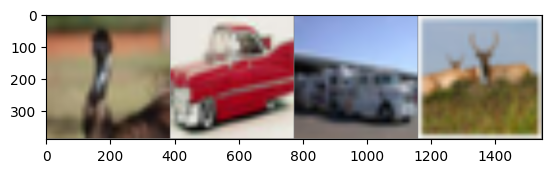

bird  car   truck deer 


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

# Model is still from timm
model = timm.create_model('vit_base_patch16_clip_384.laion2b_ft_in12k_in1k', pretrained=True)
model = model.eval()
device = torch.device("cuda")
model.compile()
model.to(device)

total_steps = 100

In [15]:
for epoch in tqdm.trange(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for step, batch in zip(range(1, total_steps + 1), trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if step % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

  0%|                                                                              | 0/2 [00:00<?, ?it/s]/home/achilibe/Code/2JITsu/venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:150: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.66s/it]

Finished Training
